In [9]:
%load_ext autoreload

%autoreload 2

import numpy as np
from scipy.stats import chi2_contingency, pearsonr, zscore, sem
import scipy.io
import pandas as pd
import matplotlib.patches as mpatches
from sklearn import mixture
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import FormatStrFormatter

# own modules
import GaussianProcess as GP
from utils import load_data_controls, load_data_patient, load_market_data
%run -i 'helperFiles/style_script.py'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def chi_square(c_data):
    
    chi_squares = {}
    
    # portfolio delta
    chi_squares['actual'] = chi2_contingency(pd.crosstab(np.sign(c_data['actual']), np.sign(c_data['d_bet'])))[0]
    
    # counterfcatual loss
    chi_squares['counterfactual'] = chi2_contingency(pd.crosstab(np.sign(c_data['counterfactual']), np.sign(c_data['d_bet'])))[0]
    
    # market delta
    chi_squares['d_market'] = chi2_contingency(pd.crosstab(np.sign(c_data['d_market']), np.sign(c_data['d_bet'])))[0]
    
    # market delta
    chi_squares['d_market_belief'] = chi2_contingency(pd.crosstab(np.sign(c_data['d_market_belief']), np.sign(c_data['d_bet'])))[0]
    
    return chi_squares

def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]

# Load data

In [11]:
data = load_data_controls('all')
all_data_controls = pd.DataFrame()

for i, subject in enumerate(data):
    subject['subj'] = i
    all_data_controls = pd.concat([all_data_controls, subject])
all_data_controls.index = np.arange(len(all_data_controls))

data = load_data_patient('all')
all_data_patients = pd.DataFrame()

for i, subject in enumerate(data):
    subject['subj'] = i
    all_data_patients = pd.concat([all_data_patients, subject])
all_data_patients.index = np.arange(len(all_data_patients))

all_data = [all_data_controls, all_data_patients]
groups = ['Controls', 'Patients']

# Show distribution of bet changes

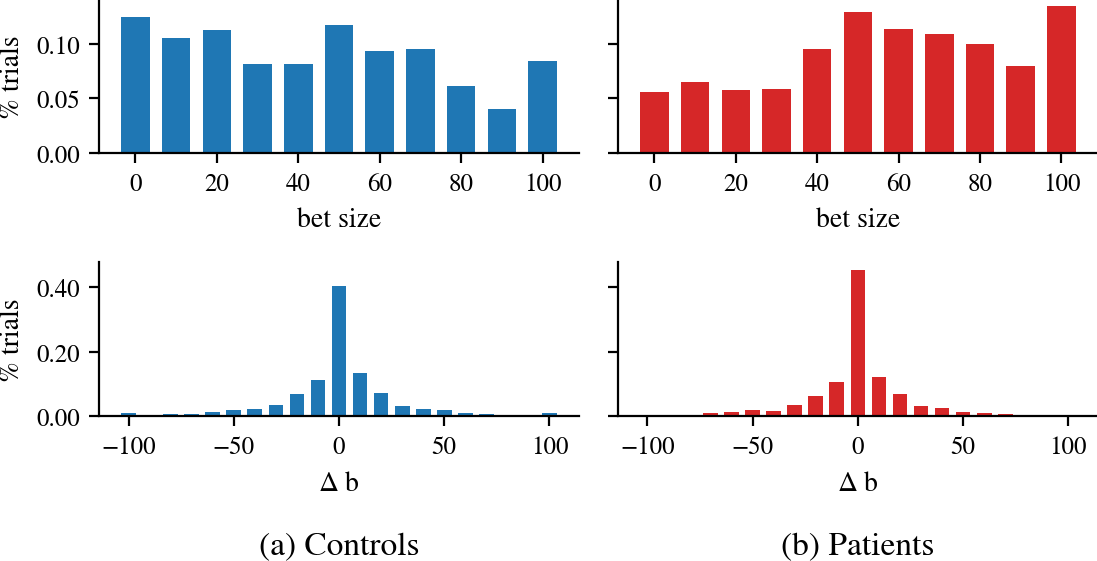

In [12]:
fig, ax = plt.subplots(2,2,figsize=(figwidth, 3.5), dpi=200, sharey='row')

for i, data in enumerate(all_data):
    weights = np.ones(len(data))/float(len(data))

    ax[0,i].hist(data['bet'], bins=np.linspace(-5,105,12), rwidth=.7, weights=weights, color=colors[i][0])
    ax[0,i].set_xlabel('bet size')
    
    if i==0:
        ax[0,i].set_ylabel('% trials')
        ax[1,i].set_ylabel('% trials')

    ax[1,i].hist(data['d_bet'], bins=np.linspace(-105,105,22), rwidth=.7, weights=weights, color=colors[i][0])
    ax[1,i].set_xlabel('$\Delta$ b')
    ax[1,i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[1,0].text(0.5, -.9, '(a) Controls', ha='center', fontsize=12,transform=ax[1,0].transAxes)
ax[1,1].text(0.5, -.9 ,'(b) Patients', ha='center', fontsize=12,transform=ax[1,1].transAxes)
    
plt.tight_layout()
plt.savefig('figures/bet_dists.pdf', dpi=600, bbox_inches='tight', pad_inches=0)


# Clustering subjects betsizes


In [14]:
groups = ['controls', 'patients']
for data, group in zip(all_data, groups):
    bet_data = pd.crosstab(data['subj'], data['bet'])

    all_preds = np.zeros((100,54))
    for seed in tqdm(range(100)):
        np.random.seed(seed)

        lowest_bic = np.infty
        bic = []

        for n_components in range(1, 4):
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(
                n_init=1000,
                n_components=n_components, 
                reg_covar=1,
                init_params='random'
            )
            gmm.fit(bet_data)
            bic.append(gmm.bic(bet_data))
            if bic[-1] < lowest_bic and bic[-1]>0:
                lowest_bic = bic[-1]
                best_gmm = gmm

        preds = best_gmm.predict(bet_data)
        all_preds[seed] = preds
    
    np.save('data/seed_preds'+ group +'.npy', all_preds)

  2%|▏         | 2/100 [01:17<1:03:41, 39.00s/it]


KeyboardInterrupt: 

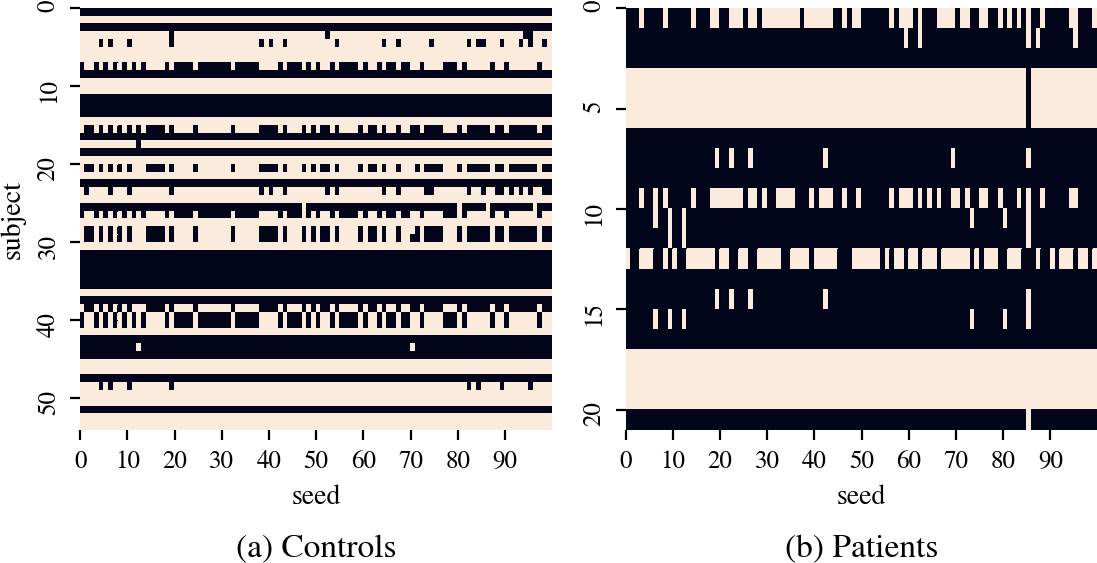

In [15]:
fig, ax = plt.subplots(1,2,figsize=(figwidth,figwidth/1.8), dpi=200)

for i, group in enumerate(groups):
    all_preds = np.load('data/seed_preds_'+ group +'.npy')
    all_preds_ = abs(all_preds-all_preds[:,2].reshape((-1,1)))
    
    sns.heatmap(all_preds_.T, cbar=False, ax=ax[i], linewidths=0, rasterized=True)
    ax[i].set_xlabel('seed')
    ax[i].set_xticks(np.arange(0,100,10))
    ax[i].set_xticklabels(np.arange(0,100,10))
    ax[i].set_yticks(np.arange(0,all_preds.shape[-1],(2-i)*5))
    ax[i].set_yticklabels(np.arange(0,all_preds.shape[-1],(2-i)*5))

    preds = np.zeros(all_preds.shape[-1])-1

    for i, p in enumerate(all_preds_.T):
        u, count = np.unique(p, return_counts=True)
        if count.max() > 90:
            preds[i] = u[np.argmax(count)]
        else:
            preds[i] = 2
        
    np.save('data/clusters_'+ group +'.npy', preds)
ax[0].set_ylabel('subject')
ax[0].text(0.5, -.3, '(a) Controls', ha='center', fontsize=12,transform=ax[0].transAxes)
ax[1].text(0.5, -.3 ,'(b) Patients', ha='center', fontsize=12,transform=ax[1].transAxes)

plt.tight_layout()
plt.savefig('figures/clusters_seed.pdf')

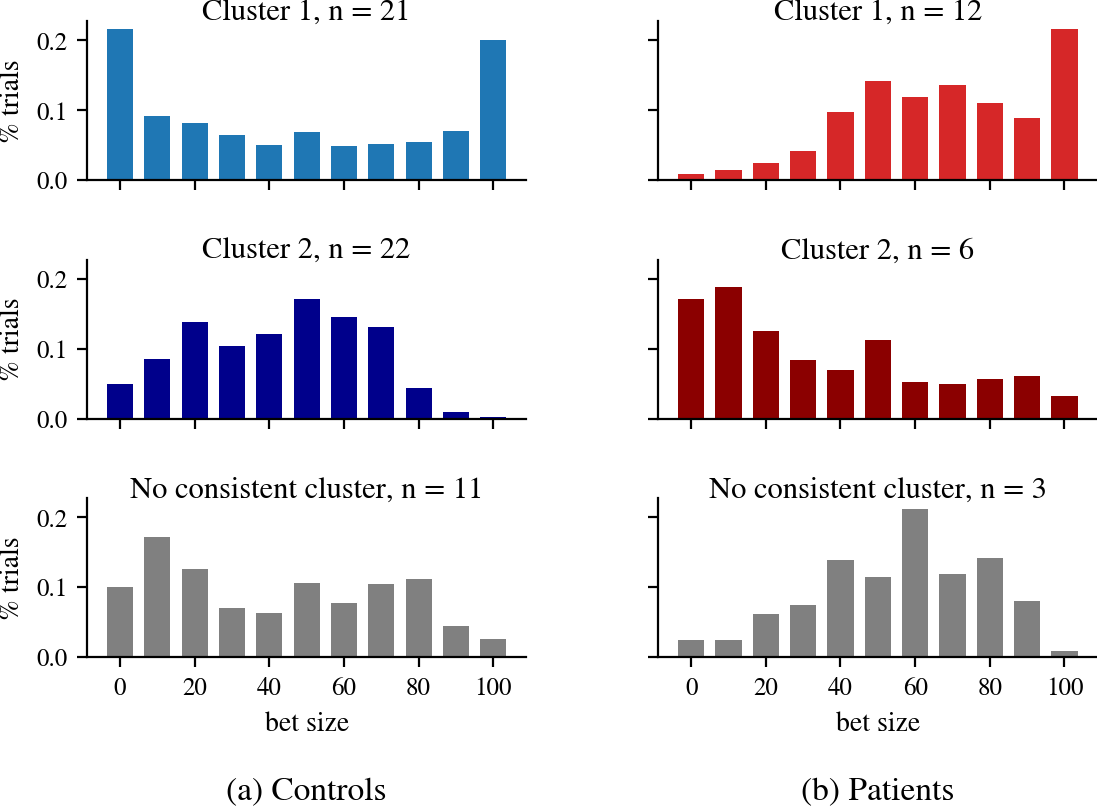

In [16]:
all_preds = [np.load('data/clusters_controls.npy'), np.load('data/clusters_patients.npy')]

fig, ax = plt.subplots(3,2,figsize=(figwidth,4.5), dpi=200, sharey=True, sharex=True)

for i, (data, preds) in enumerate(zip(all_data, all_preds)):
    bet_data = pd.crosstab(data['subj'], data['bet'])

    for j in range(3):

        ax[j,i].bar(np.arange(0,101,10), bet_data[preds==j].sum(axis=0)/bet_data[preds==j].sum().sum(), width=7, color=colors[i][j])
        if j==2:
            ax[j,i].set_title('No consistent cluster, n = %d' % ((preds==j).sum()), y=.9)
        else:
            ax[j,i].set_title('Cluster %d, n = %d' % (j+1, (preds==j).sum()), y=.9)
        
        if i==0:
            ax[j,i].set_ylabel('% trials')
        ax[j,i].set_xticks(np.arange(0,110,20))    
    ax[j,i].set_xlabel('bet size')

ax[2,0].text(0.5, -.9, '(a) Controls', ha='center', fontsize=12,transform=ax[2,0].transAxes)
ax[2,1].text(0.5, -.9 ,'(b) Patients', ha='center', fontsize=12,transform=ax[2,1].transAxes)

plt.tight_layout()
plt.subplots_adjust(wspace=.3, hspace=.5)
plt.savefig('figures/clusters.pdf')

<ipython-input-17-fb2ad1ac4dc8>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .95, 1])


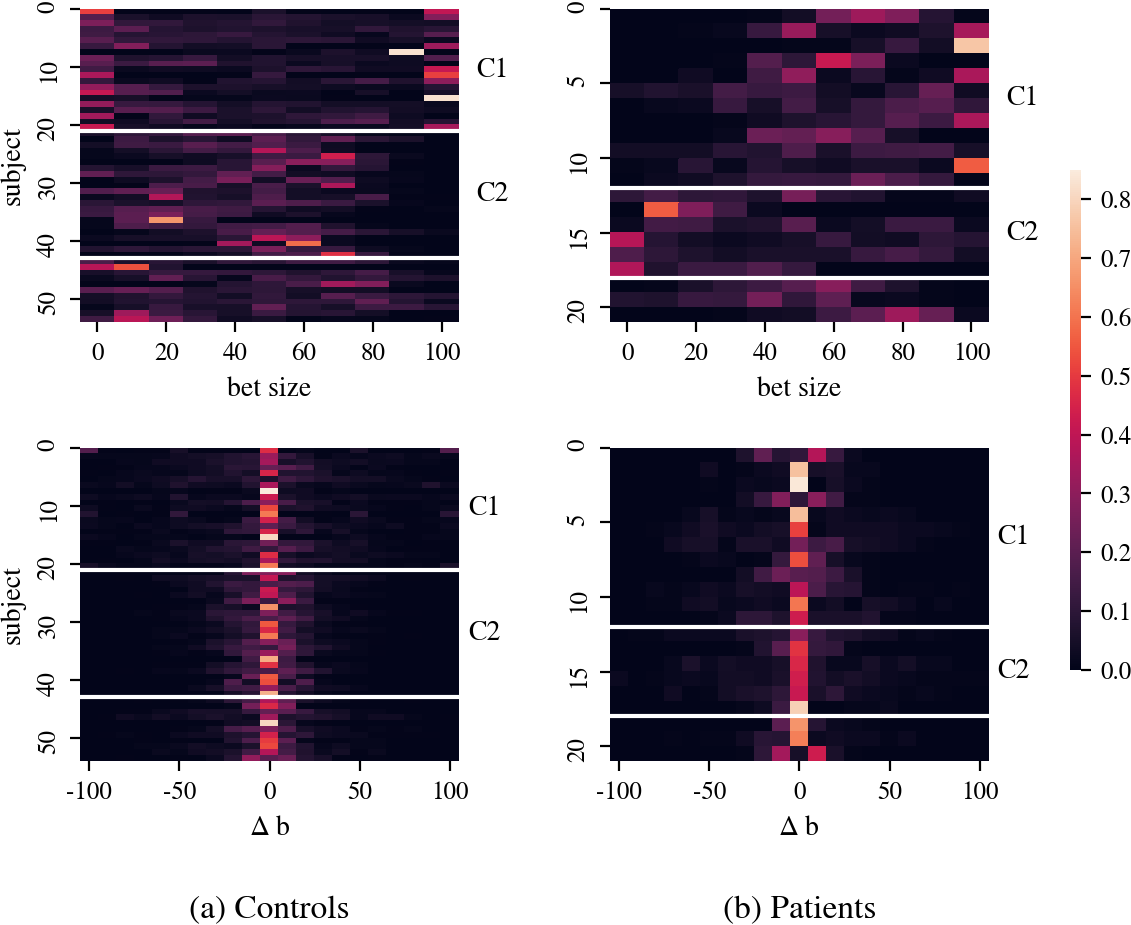

In [17]:
fig, axs = plt.subplots(2,2, figsize=(figwidth,5), dpi=200)
cbar_ax = fig.add_axes([.95, .3, .01, .5])
data_ = [load_data_controls('all'), load_data_patient('all')]
n=3

for j, (data, preds) in enumerate(zip(data_, all_preds)):
    
    bins = np.linspace(-5,105,12)
    freqs = []
    for cluster in range(3):
        for i, subject in enumerate(data):
            if not preds[i]==cluster:
                continue
            bets = subject['bet']
            freq = np.histogram(bets, bins=bins)[0]
            freqs.append(freq/freq.sum())
    
    for i in range(n-1):
        n_class = (preds<=i).sum()
        axs[0,j].hlines(n_class,0,21, color='white')
        axs[0,j].text(len(bins)-.5, (preds<=i).sum()-(preds==i).sum()/2, 'C'+str(i+1), va='center')
    
    sns.heatmap(freqs, xticklabels=[int(x) for x in np.linspace(0,100,11)], ax=axs[0,j], vmin=0, vmax=.85, cbar=False, rasterized=True)
    
    axs[0,j].set_xlabel('bet size')
    axs[0,j].set_xticks(np.arange(0,11,2)+.5)
    axs[0,j].tick_params(axis='x', labelrotation=0)
    axs[0,j].set_yticks(np.arange(0,preds.shape[-1],(2-j)*5))
    axs[0,j].set_yticklabels(np.arange(0,preds.shape[-1],(2-j)*5))

    
    bins = np.linspace(-105,105,22)
    freqs = []
    for cluster in range(3):
        for i, subject in enumerate(data):
            if not preds[i]==cluster:
                    continue
            d_bets = subject['d_bet']
            freq = np.histogram(d_bets, bins=bins)[0]
            freqs.append(freq/freq.sum())

    for i in range(n-1):
        n_class =(preds<=i).sum()
        axs[1,j].hlines(n_class,0,21, color='white')
        axs[1,j].text(len(bins)-.5, (preds<=i).sum()-(preds==i).sum()/2, 'C'+str(i+1), va='center')

    im=sns.heatmap(freqs, xticklabels=[int(x) for x in np.linspace(-100,100,21)], ax=axs[1,j], vmin=0, vmax=.85,  cbar_ax=cbar_ax, rasterized=True)
    axs[1,j].set_xlabel('$\Delta$ b')
    axs[1,j].set_xticks(np.arange(0,21,5)+.5)
    axs[1,j].tick_params(axis='x', labelrotation=0)
    axs[1,j].set_yticks(np.arange(0,preds.shape[-1],(2-j)*5))
    axs[1,j].set_yticklabels(np.arange(0,preds.shape[-1],(2-j)*5))
    
    if j==0:
        axs[0,j].set_ylabel('subject')
        axs[1,j].set_ylabel('subject')

axs[1,0].text(0.5, -.5, '(a) Controls', ha='center', fontsize=12,transform=axs[1,0].transAxes)
axs[1,1].text(0.5, -.5 ,'(b) Patients', ha='center', fontsize=12,transform=axs[1,1].transAxes)

plt.tight_layout(rect=[0, 0, .95, 1])
plt.subplots_adjust(wspace=.4, hspace=.4)
plt.savefig('figures/dists_clusters.pdf')

# Performance first half vs second half/ Learning

In [20]:
data_controls = load_data_controls('all')
first_controls = []
second_controls = []

for i, subject in enumerate(data_controls):
    n = len(subject)
    portfolios = pd.concat([pd.Series([100]), subject.portfolio[:-1]], ignore_index=True)
    first_controls.append(np.nanmean(subject.actual[:int(n/2)].values/portfolios[:int(n/2)]))
    second_controls.append(np.nanmean(subject.actual[int(n/2):].values/portfolios[int(n/2):]))

data_patients = load_data_patient('all')
first_patients = []
second_patients = []

for i, subject in enumerate(data_patients):
    n = len(subject)
    portfolios = pd.concat([pd.Series([100]), subject.portfolio[:-1]], ignore_index=True)
    first_patients.append(np.nanmean(subject.actual[:int(n/2)].values/portfolios[:int(n/2)]))
    second_patients.append(np.nanmean(subject.actual[int(n/2):].values/portfolios[int(n/2):]))
    



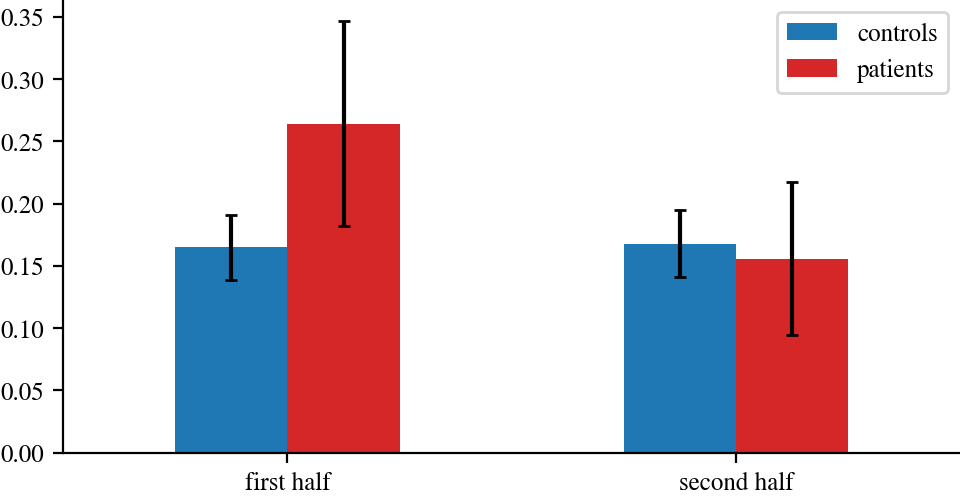

In [28]:
fig, axs = plt.subplots(figsize=(figwidth,3), dpi=200)

controls = [np.mean(first_controls)*100, np.mean(second_controls)*100]
err_controls = [sem(first_controls)*100, sem(second_controls)*100]

patients = [np.mean(first_patients)*100, np.mean(second_patients)*100]
err_patients = [sem(first_patients)*100, sem(second_patients)*100]
index = ['first half', 'second half']


df = pd.DataFrame({'controls': controls,
                   'patients': patients}, index=index)
ax = df.plot.bar(rot=0, ax=axs, yerr=[err_controls, err_patients], capsize=2, color=[colors[0][0], colors[1][0]])


# Gaussian Processes

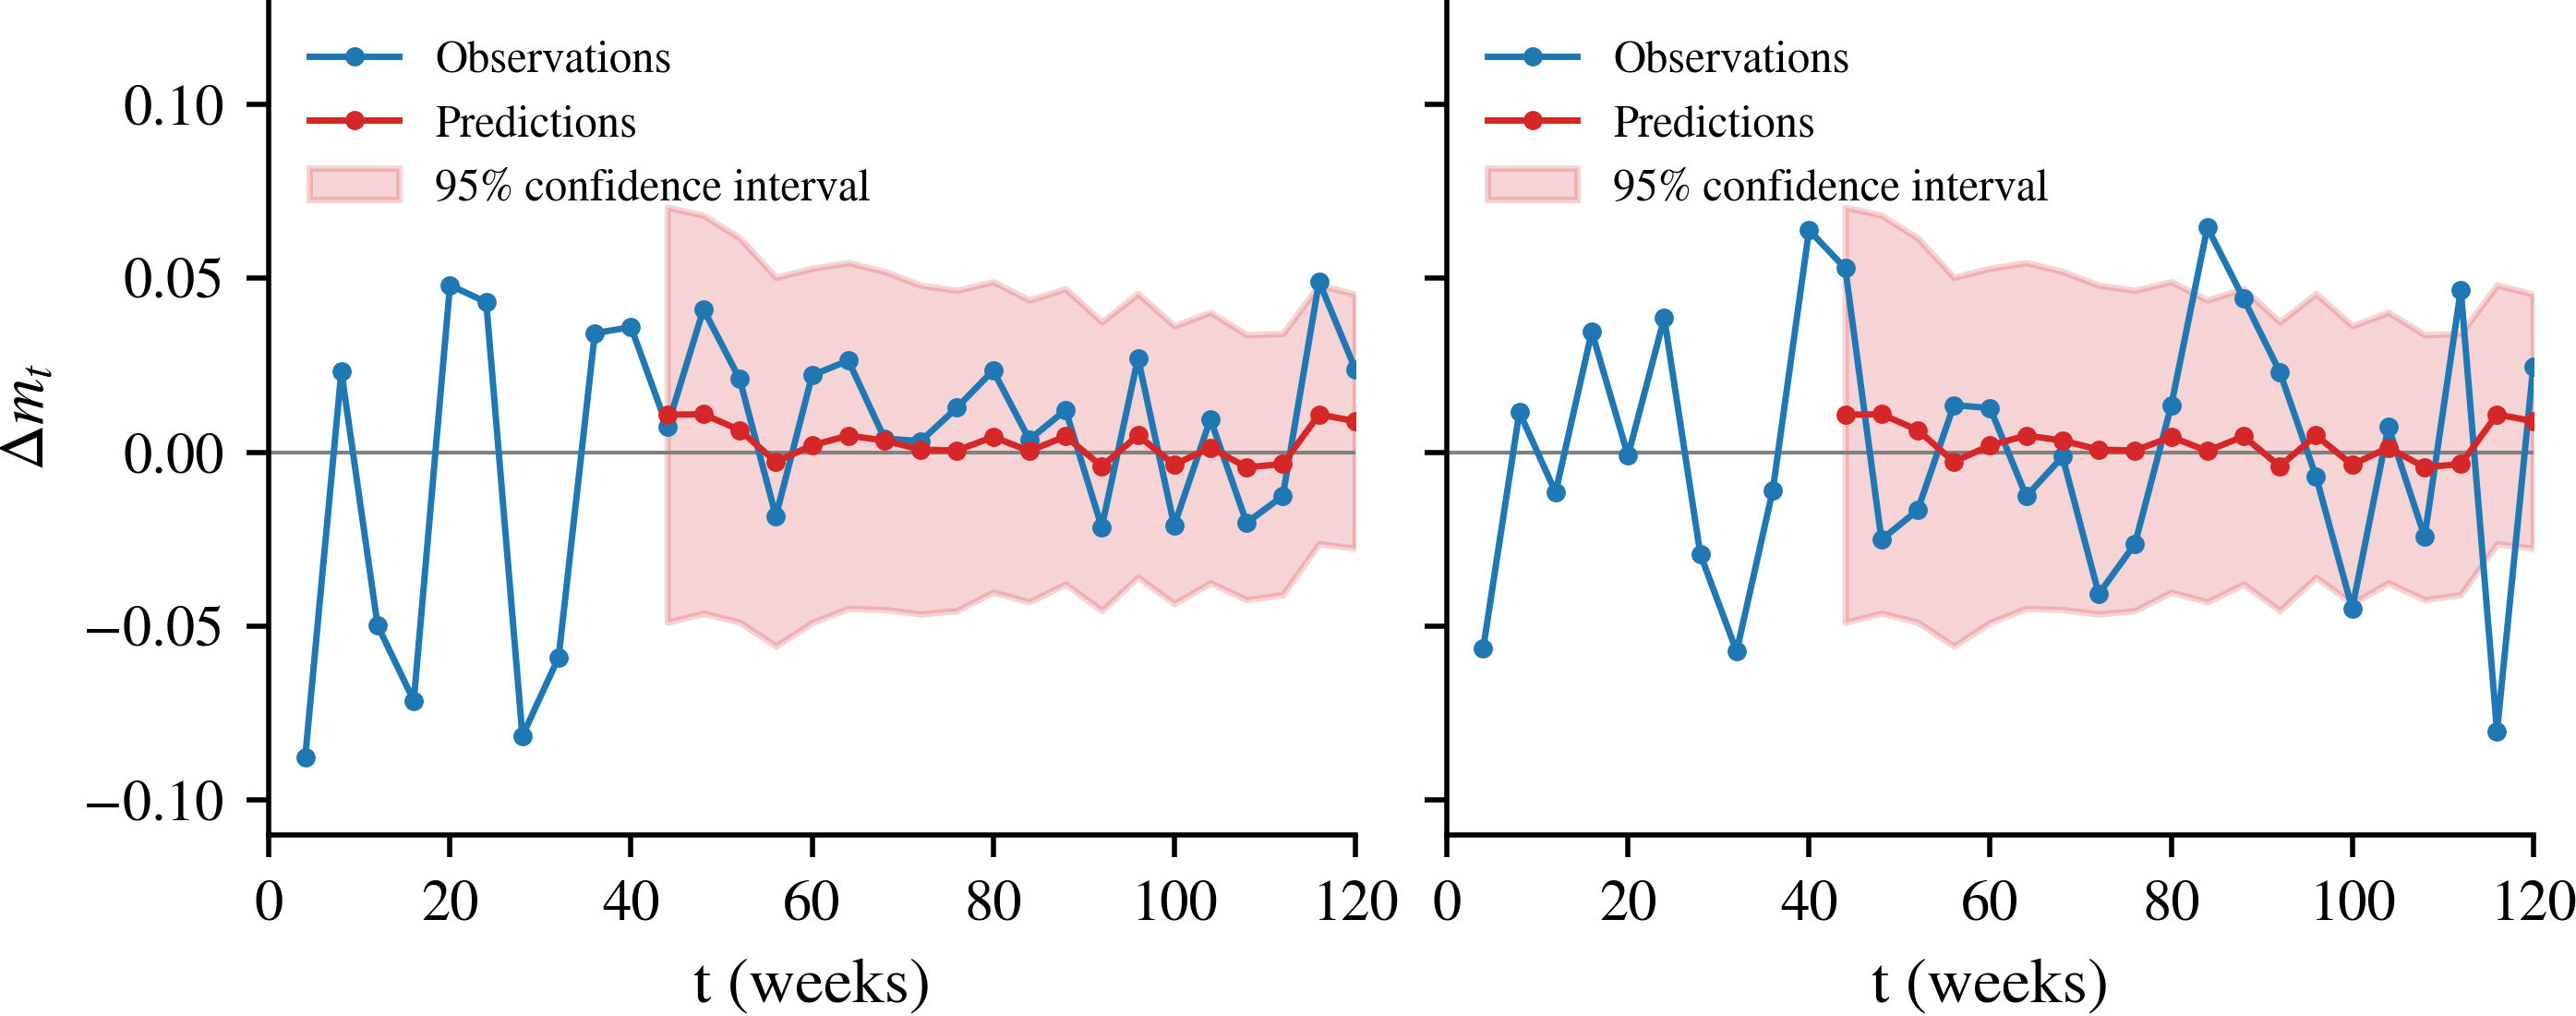

In [30]:
market_data = np.load('data/markets.npy')

fig, ax = plt.subplots(1,2,figsize=(figwidth,2.5), dpi=500, sharey=True)

for i, p_id in enumerate([1,2]):
    mat = scipy.io.loadmat('./data/Bubble_patients_raw//Behaviour/bubble_P' + str(p_id) + '.mat')
    mdata = mat['data']
    mdtype = mdata.dtype
    ndata = {n: mdata[n][0, 0][0] for n in mdtype.names}
    p_data = pd.DataFrame.from_dict(ndata)
    p_data = p_data.dropna()
    p_data['marketRound'] = p_data['marketRound'] - 11

    market = p_data['marketId'][0]
    marketVals= market_data[market][::4]
    market_return = GP.market_return(marketVals)

    data = load_data_patient(0)[:20]

    ax[i].plot(np.arange(4,121,4), market_return, linewidth=1, marker='o', markersize=2, label='Observations')
    ax[i].plot(np.arange(44,121,4),data['d_market_belief'], 'tab:red', linewidth=1, marker='o', markersize=2, label='Predictions')
    ax[i].fill_between(np.arange(44,121,4),
                    data['d_market_belief'] - 1.96 * data['d_market_uncertainty'],
                    data['d_market_belief'] + 1.96 * data['d_market_uncertainty'],
                    color='tab:red',
                    alpha=.2,
                    label='95% confidence interval')
    ax[i].hlines(0, 0,120, 'gray', linewidth=.6)
    ax[i].set_xlim(0,120)
    ax[i].set_xlabel('t (weeks)')
    if i == 0:
        ax[i].set_ylabel('$\Delta m_t$')
    ax[i].legend(fontsize=7, loc='upper left', frameon=False)


ax[1].set_ylim(-.11,.13)
plt.tight_layout()
plt.savefig('figures/Gassuian_process.pdf', dpi=400, pad_inches=0, bbox_inches='tight')

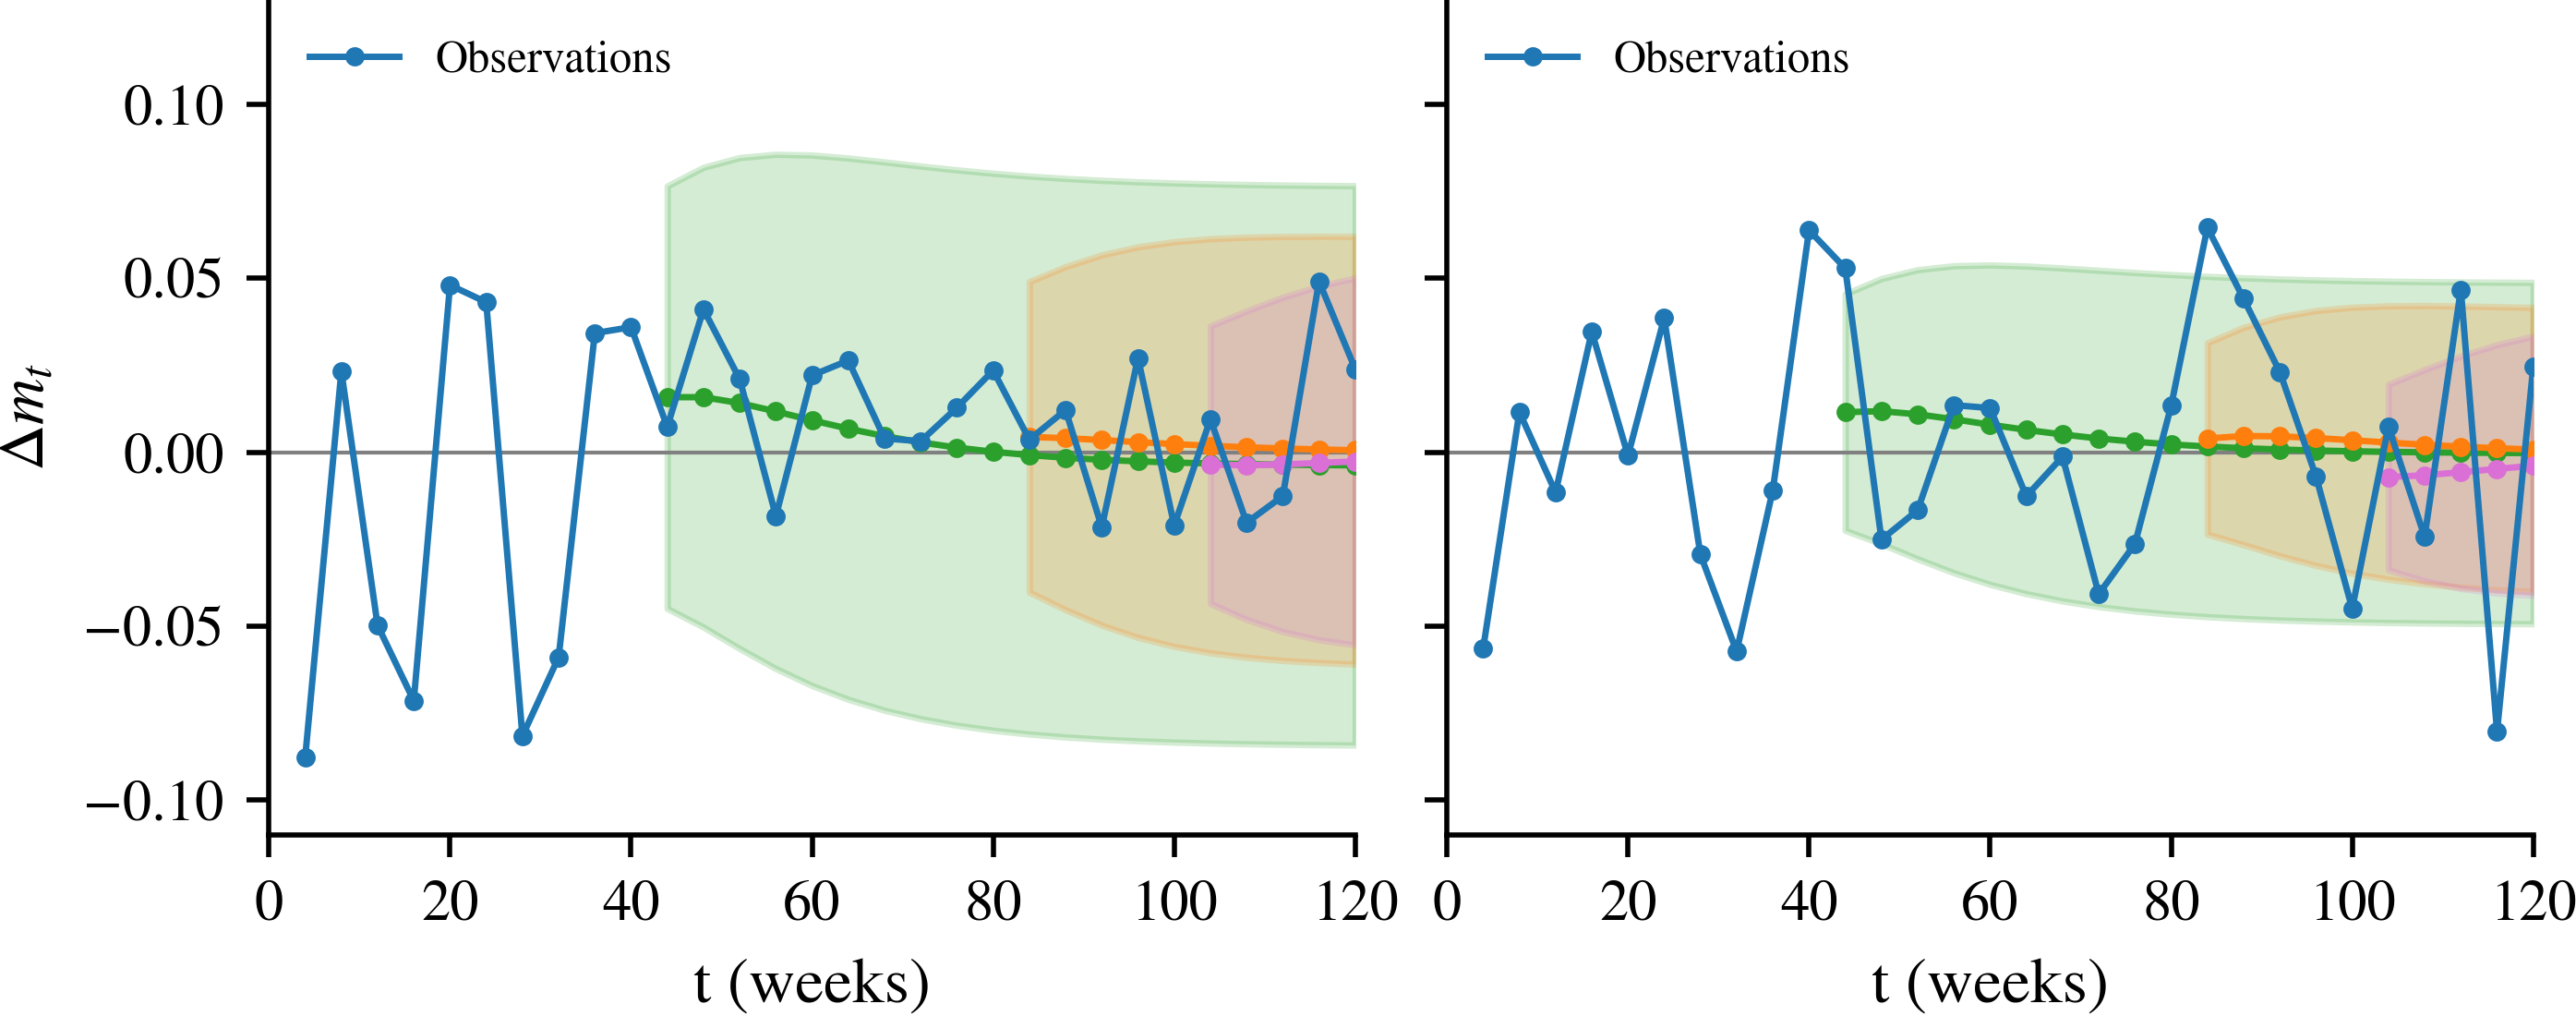

In [32]:
fig, ax = plt.subplots(1,2,figsize=(figwidth,2.5), dpi=500, sharey=True)
colors = ['tab:green', 'tab:orange', 'orchid', ]
kernel_params = {
    'length_scale': 20,
    'nu': 1.5,
}

for i, p_id in enumerate([1,2]):
    mat = scipy.io.loadmat('./data/Bubble_patients_raw//Behaviour/bubble_P' + str(p_id) + '.mat')
    mdata = mat['data']
    mdtype = mdata.dtype
    ndata = {n: mdata[n][0, 0][0] for n in mdtype.names}
    p_data = pd.DataFrame.from_dict(ndata)
    p_data = p_data.dropna()
    p_data['marketRound'] = p_data['marketRound'] - 11

    market = p_data['marketId'][0]
    marketVals= market_data[market]
    market_return = GP.market_return(marketVals[::4])
    
    for t, color in zip([0,40,60], colors):
        m_data = marketVals[:41+t]
        mu, sigma = GP.pred_market_delta_whole(m_data, kernel_params) 
        ax[i].plot(np.arange(44+t,121,4), mu, color=color, linewidth=1, marker='o', markersize=2)
        ax[i].fill_between(np.arange(44+t,121,4),
                    mu - 1.96 * sigma,
                    mu + 1.96 * sigma,
                    color=color,
                    alpha=.2)

    
    ax[i].plot(np.arange(4,121,4), market_return, linewidth=1, marker='o', markersize=2, label='Observations')
   
    ax[i].hlines(0, 0,120, 'gray', linewidth=.6)
    ax[i].set_xlim(0,120)
    ax[i].set_xlabel('t (weeks)')
    if i == 0:
        ax[i].set_ylabel('$\Delta m_t$')
    ax[i].legend(fontsize=7, loc='upper left', frameon=False)


ax[1].set_ylim(-.11,.13)
plt.tight_layout()
plt.savefig('figures/Gassuian_process_receiding.pdf', dpi=400, pad_inches=0, bbox_inches='tight')

Text(0.5, 1.0, 'Samples from prior distribution')

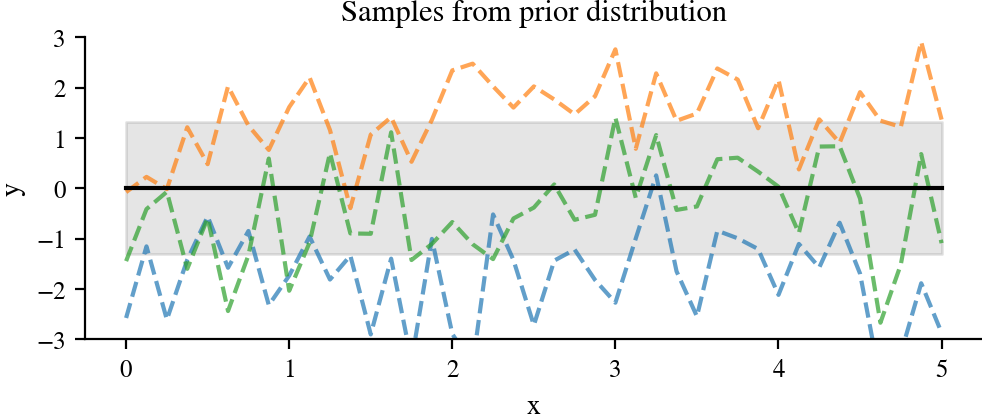

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

kernel_params = {'length_scale': 20, 'nu':1.5}

def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 5, 41)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim([-3, 3])
    
kernel = 1.0 * Matern(**kernel_params) + WhiteKernel(noise_level=kernel_params['length_scale']*np.std(market_return))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

fig, axs = plt.subplots(figsize=(figwidth, 2), dpi=200)

# plot prior
n_samples = 3
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs)
axs.set_title("Samples from prior distribution")

# Look at contigencies

In [34]:
data_ = [load_data_controls('all'), load_data_patient('all')]
n=3

for j, (data, group, preds) in enumerate(zip(data_, groups, all_preds)):
    
    for cluster in [0, 1]:
        dat = pd.DataFrame()

        for i, subject in enumerate(data):
            if not preds[i]==cluster:
                continue
            dat = dat.append(subject, ignore_index=True)
        chi_squares = pd.DataFrame.from_dict(chi_square(dat), orient='index')

        print('\nGroup: ' + group)
        print('Cluster: ' + str(cluster +1))
        print('Chi squares mean \n' + str(chi_squares))
#         print('Chi squares sem \n' + str(chi_squares.sem()))


Group: controls
Cluster: 1
Chi squares mean 
                           0
actual           1038.441373
counterfactual    984.387208
d_market          533.913155
d_market_belief   379.511651

Group: controls
Cluster: 2
Chi squares mean 
                          0
actual           544.665062
counterfactual   415.978811
d_market         410.773330
d_market_belief  297.510482

Group: patients
Cluster: 1
Chi squares mean 
                          0
actual            36.006008
counterfactual   210.799609
d_market          26.113505
d_market_belief   25.994731

Group: patients
Cluster: 2
Chi squares mean 
                          0
actual           113.336847
counterfactual    81.716541
d_market          66.655340
d_market_belief   41.237460


In [35]:
for j, (data_, group) in enumerate(zip(all_data, groups)):
    p_values = pd.DataFrame()
    chi_squares = pd.DataFrame()
    preds = np.load('data/clusters_'+ group +'.npy')
    
    for cluster in [0, 1]:
        data = data_[data_['subj']==cluster]
        p_coeff = pd.DataFrame(data.corr(method=pearsonr_pval)['d_bet']).T.drop(columns=['portfolio', 'd_bet', 'actual', 'counterfactual', 'rpe', 'd_market', 'subj'])
        print('\nGroup: ' + group)
        print('Cluster: ' + str(cluster +1))
        print('P_values: \n' + str(p_coeff.mean()))



Group: controls
Cluster: 1
P_values: 
bet                       1.248705e-27
d_market_belief           5.422324e-05
d_market_uncertainty      9.506218e-01
regret                    2.479477e-12
rejoice                   2.218679e-01
counterfactual_regret     1.707983e-15
counterfactual_rejoice    1.822828e-01
dtype: float64

Group: controls
Cluster: 2
P_values: 
bet                       5.800614e-06
d_market_belief           1.107209e-09
d_market_uncertainty      6.795457e-01
regret                    2.394177e-05
rejoice                   1.818603e-01
counterfactual_regret     8.860231e-08
counterfactual_rejoice    8.213003e-02
dtype: float64

Group: patients
Cluster: 1
P_values: 
bet                       0.017004
d_market_belief           0.014654
d_market_uncertainty      0.899784
regret                    0.342099
rejoice                   0.389072
counterfactual_regret     0.013603
counterfactual_rejoice    0.732321
dtype: float64

Group: patients
Cluster: 2
P_values: 
bet     

/home/lu/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/lu/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/lu/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/lu/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [36]:
for j, (data_, group) in enumerate(zip(all_data, groups)):
    preds = np.load('data/clusters_'+ group +'.npy')
    
    for cluster in [0, 1]:
        data = data_[data_['subj']==cluster]
        corr_coeff = pd.DataFrame(data.corr(method ='pearson')['d_bet']).T.drop(columns=['portfolio', 'd_bet', 'actual', 'counterfactual', 'rpe', 'd_market', 'subj'])
        print('\nGroup: ' + group)
        print('Cluster: ' + str(cluster +1))
        print('Cor_coeffs: \n' + str(corr_coeff.mean()))


Group: controls
Cluster: 1
Cor_coeffs: 
bet                      -0.673230
d_market_belief           0.282093
d_market_uncertainty     -0.004418
regret                   -0.470043
rejoice                  -0.086979
counterfactual_regret     0.525037
counterfactual_rejoice    0.094932
dtype: float64

Group: controls
Cluster: 2
Cor_coeffs: 
bet                      -0.315132
d_market_belief           0.414916
d_market_uncertainty      0.029462
regret                   -0.294651
rejoice                   0.095023
counterfactual_regret     0.368080
counterfactual_rejoice   -0.123542
dtype: float64

Group: patients
Cluster: 1
Cor_coeffs: 
bet                      -0.218438
d_market_belief           0.223274
d_market_uncertainty     -0.011667
regret                   -0.087848
rejoice                   0.079671
counterfactual_regret     0.225660
counterfactual_rejoice   -0.031681
dtype: float64

Group: patients
Cluster: 2
Cor_coeffs: 
bet                      -0.749935
d_market_belief      